In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
import re
import warnings
import json
import random
from IPython.display import display

# Tắt cảnh báo
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Thiết lập Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Các hàm tính chỉ số bổ sung
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

def calculate_da(y_true, y_pred):
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    return np.mean((true_diff * pred_diff) > 0) * 100

# Cấu hình thiết bị
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- CẤU HÌNH HYPERPARAMETERS ---
SEQ_LEN = 30
HIDDEN_DIM = 128
DROPOUT = 0.2
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# --- CẤU HÌNH ĐƯỜNG DẪN ---
PRICE_DIR = os.path.join("..", "..", "DATASET", "PRICE")
CHART_DIR = os.path.join("..", "..", "CHART", "DLINEAR+NODE")
LOG_DIR = os.path.join("..", "..", "LOGS", "DLINEAR+NODE")

os.makedirs(CHART_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

Using device: cpu


In [7]:
class HybridDLinearNodeModel(nn.Module):
    def __init__(self, seq_len=30, price_dim=5, residual_dim=5, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.price_dim = price_dim
        self.residual_dim = residual_dim
        
        self.trend_dlinear = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len)
        )
        
        self.residual_dlinear = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len)
        )
        
        self.node_func = nn.Sequential(
            nn.Linear(price_dim + residual_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, price_dim + residual_dim)
        )
        
        self.fusion = nn.Sequential(
            nn.Linear((price_dim + residual_dim) * seq_len, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.predictor = nn.Linear(hidden_dim // 2, 1)
        
    def forward(self, price_x, residual_x):
        batch_size, seq_len, _ = price_x.shape
        combined_input = torch.cat([price_x, residual_x], dim=-1)
        
        price_trend = self.trend_dlinear(price_x.transpose(1, 2)).transpose(1, 2)
        residual_processed = self.residual_dlinear(residual_x.transpose(1, 2)).transpose(1, 2)
        
        dlinear_output = torch.cat([price_trend, residual_processed], dim=-1)
        node_output = combined_input + self.node_func(combined_input)
        
        hybrid_features = dlinear_output + node_output
        flattened = hybrid_features.reshape(batch_size, -1)
        fused = self.fusion(flattened)
        return self.predictor(fused)

In [8]:
class HybridDataProcessor:
    def __init__(self):
        self.scalers = {
            'price': StandardScaler(),
            'res': StandardScaler(),
            'target': StandardScaler()
        }
        
    def load_clean_data(self, file_path):
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        column_mapping = {
            'Date': 'Ngày', 'Time': 'Ngày', 'date': 'Ngày',
            'Close': 'Lần cuối', 'Price': 'Lần cuối', 'Last': 'Lần cuối',
            'Open': 'Mở', 'High': 'Cao', 'Low': 'Thấp',
            'Vol': 'KL', 'Volume': 'KL', 'Khối lượng': 'KL'
        }
        df.columns = [column_mapping.get(c, c) for c in df.columns]
        df['Ngày'] = pd.to_datetime(df['Ngày'], dayfirst=True, errors='coerce')
        
        # --- THÊM: Xử lý trùng lặp và sắp xếp ---
        df = df.dropna(subset=['Ngày', 'Lần cuối'])
        df = df.drop_duplicates(subset=['Ngày']).sort_values('Ngày')
        
        price_cols = ['Lần cuối', 'Mở', 'Cao', 'Thấp', 'KL']
        for col in price_cols:
            if col in df.columns:
                if df[col].dtype == 'object':
                    df[col] = df[col].astype(str).str.replace(',', '').str.replace('M', 'e6').str.replace('K', 'e3')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df[price_cols] = df[price_cols].ffill().bfill()
        price_data = df[price_cols].values
        # Tính Residual (Giá - SMA 20)
        res_data = price_data - pd.DataFrame(price_data).rolling(window=20, min_periods=1).mean().values
        
        return df['Ngày'].values, price_data, res_data, df['Lần cuối'].values

    def prepare_sequences(self, dates, p_data, r_data, target, seq_len=30):
        p_scaled = self.scalers['price'].fit_transform(p_data)
        r_scaled = self.scalers['res'].fit_transform(r_data)
        t_scaled = self.scalers['target'].fit_transform(target.reshape(-1, 1)).flatten()
        
        X_p, X_r, Y, Y_dates = [], [], [], []
        for i in range(seq_len, len(t_scaled)):
            X_p.append(p_scaled[i-seq_len:i])
            X_r.append(r_scaled[i-seq_len:i])
            Y.append(t_scaled[i])
            Y_dates.append(dates[i])
            
        return np.array(X_p), np.array(X_r), np.array(Y), np.array(Y_dates)

In [9]:
def train_model(model, train_loader, val_loader, stock_name, epochs=150):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}
    
    print(f"Training {stock_name}...")
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for p, r, y in train_loader:
            p, r, y = p.to(DEVICE), r.to(DEVICE), y.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            loss = criterion(model(p, r), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for p, r, y in val_loader:
                p, r, y = p.to(DEVICE), r.to(DEVICE), y.to(DEVICE).unsqueeze(1)
                v_loss += criterion(model(p, r), y).item()
        
        history["train_loss"].append(train_loss/len(train_loader))
        history["val_loss"].append(v_loss/len(val_loader))
        
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} - Loss: {history['train_loss'][-1]:.6f}")

    save_path = os.path.join(LOG_DIR, f"{stock_name}_Hybrid.pt")
    torch.save(model.state_dict(), save_path)
    return history, save_path

def visualize_prediction(model, processor, p_test, r_test, y_test, stock_name, dates):
    model.eval()
    with torch.no_grad():
        preds_scaled = model(p_test.to(DEVICE), r_test.to(DEVICE)).cpu().numpy()
        preds = processor.scalers['target'].inverse_transform(preds_scaled).flatten()
        actual = processor.scalers['target'].inverse_transform(y_test.cpu().numpy().reshape(-1, 1)).flatten()

    plot_dates = pd.to_datetime(dates[-len(actual):])
    date_fmt = mdates.DateFormatter('%d/%m')

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.25)

    # Chart [0, 0]: Overall
    axes[0, 0].plot(plot_dates, actual, label='Thực tế', color='blue', alpha=0.6)
    axes[0, 0].plot(plot_dates, preds, label='Dự báo', color='red', linestyle='--')
    axes[0, 0].set_title(f'Dự báo Tổng thể (Hybrid) - {stock_name}')
    axes[0, 0].xaxis.set_major_formatter(date_fmt)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Chart [0, 1]: Scatter plot
    axes[0, 1].scatter(actual, preds, alpha=0.5, color='purple', s=10)
    axes[0, 1].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=1)
    axes[0, 1].set_title('Tương quan Thực tế vs Dự báo')
    axes[0, 1].set_xlabel('Giá Thực tế')
    axes[0, 1].set_ylabel('Giá Dự báo')

    # Chart [1, 0]: Zoom last 5 days
    last_n = 5
    axes[1, 0].plot(plot_dates[-last_n:], actual[-last_n:], marker='o', label='Thực tế', color='blue')
    axes[1, 0].plot(plot_dates[-last_n:], preds[-last_n:], marker='x', label='Dự báo', color='red', linestyle='--')
    axes[1, 0].set_title(f'{last_n} ngày cuối cùng')
    axes[1, 0].xaxis.set_major_formatter(date_fmt)
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Chart [1, 1]: Error (%)
    error_pct = np.abs((actual - preds) / (actual + 1e-9)) * 100
    axes[1, 1].bar(plot_dates[-20:], error_pct[-20:], color='orange', alpha=0.6)
    axes[1, 1].set_title('Sai số (%) - 20 ngày cuối')
    axes[1, 1].xaxis.set_major_formatter(date_fmt)
    axes[1, 1].set_ylabel('% Error')
    
    fig.autofmt_xdate()

    plot_filename = f"{stock_name}_Hybrid_forecast_2x2.png"
    plt.savefig(os.path.join(CHART_DIR, plot_filename), bbox_inches='tight', dpi=150)
    plt.show()
    plt.close(fig)

    # Calculate metrics
    mse = mean_squared_error(actual, preds)
    return {
        "Ticker": stock_name,
        "Mode": "Hybrid",
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "MAE": mean_absolute_error(actual, preds),
        "MAPE (%)": calculate_mape(actual, preds),
        "R2": r2_score(actual, preds),
        "DA (%)": calculate_da(actual, preds),
        "Actual Last": actual[-1],
        "Pred Last": preds[-1]
    }


==================== ĐANG XỬ LÝ MÃ: ALIBABA ====================
Training ALIBABA...
Epoch 1/150 - Loss: 0.109142
Epoch 20/150 - Loss: 0.020849
Epoch 40/150 - Loss: 0.018665
Epoch 60/150 - Loss: 0.017030
Epoch 80/150 - Loss: 0.016955
Epoch 100/150 - Loss: 0.015641
Epoch 120/150 - Loss: 0.016630
Epoch 140/150 - Loss: 0.017709


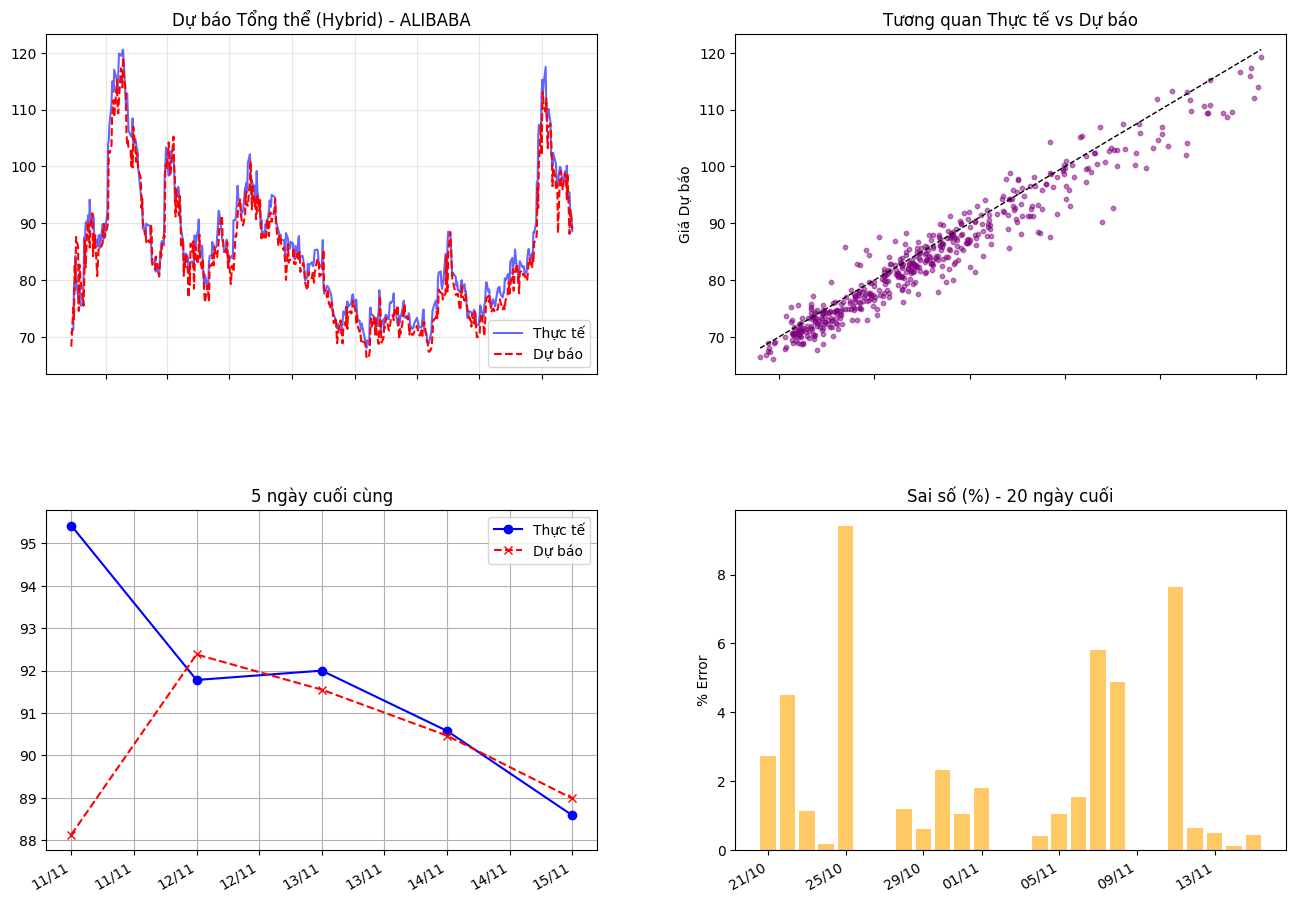

 >>> Hoàn thành: ALIBABA

==================== ĐANG XỬ LÝ MÃ: AMAZON ====================
Training AMAZON...
Epoch 1/150 - Loss: 0.113286
Epoch 20/150 - Loss: 0.005126
Epoch 40/150 - Loss: 0.002997
Epoch 60/150 - Loss: 0.011356
Epoch 80/150 - Loss: 0.005685
Epoch 100/150 - Loss: 0.004192
Epoch 120/150 - Loss: 0.005267
Epoch 140/150 - Loss: 0.004371


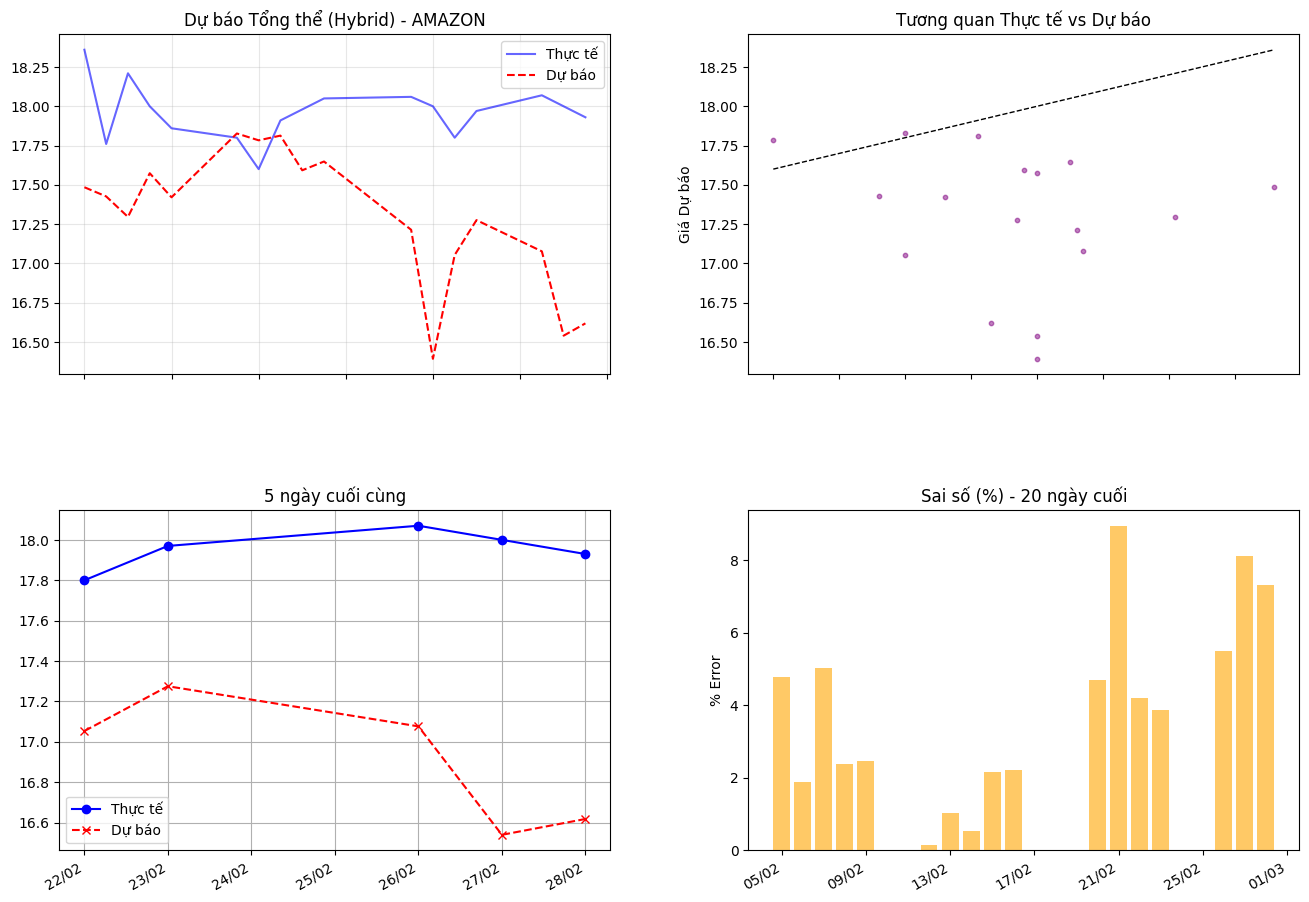

 >>> Hoàn thành: AMAZON

==================== ĐANG XỬ LÝ MÃ: GOOGLE ====================
Training GOOGLE...
Epoch 1/150 - Loss: 0.142152
Epoch 20/150 - Loss: 0.022153
Epoch 40/150 - Loss: 0.018696
Epoch 60/150 - Loss: 0.013742
Epoch 80/150 - Loss: 0.013281
Epoch 100/150 - Loss: 0.011780
Epoch 120/150 - Loss: 0.013071
Epoch 140/150 - Loss: 0.012032


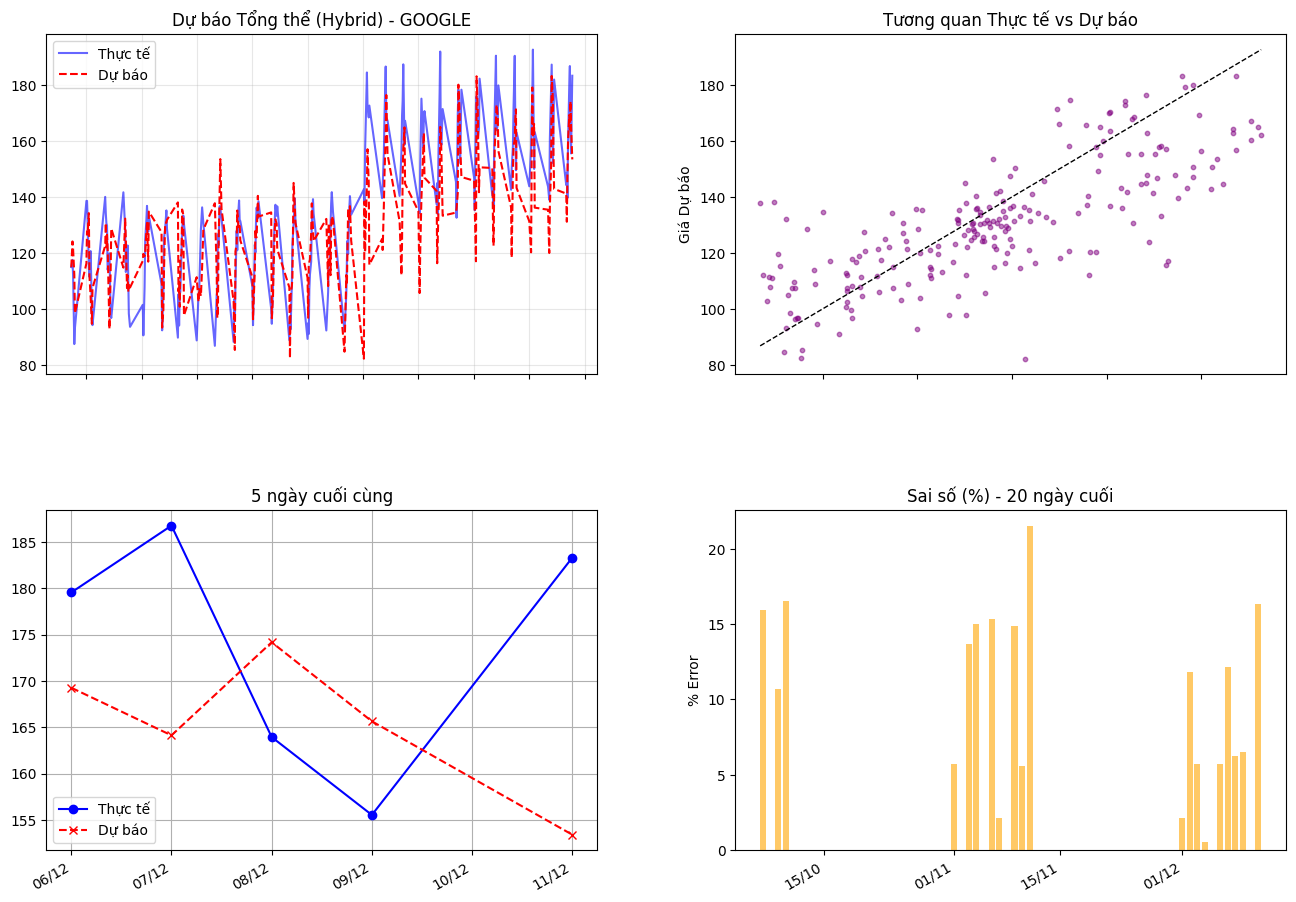

 >>> Hoàn thành: GOOGLE

==================== ĐANG XỬ LÝ MÃ: META ====================
Training META...
Epoch 1/150 - Loss: 0.034012
Epoch 20/150 - Loss: 0.006112
Epoch 40/150 - Loss: 0.005139
Epoch 60/150 - Loss: 0.004432
Epoch 80/150 - Loss: 0.004339
Epoch 100/150 - Loss: 0.003798
Epoch 120/150 - Loss: 0.004192
Epoch 140/150 - Loss: 0.004713


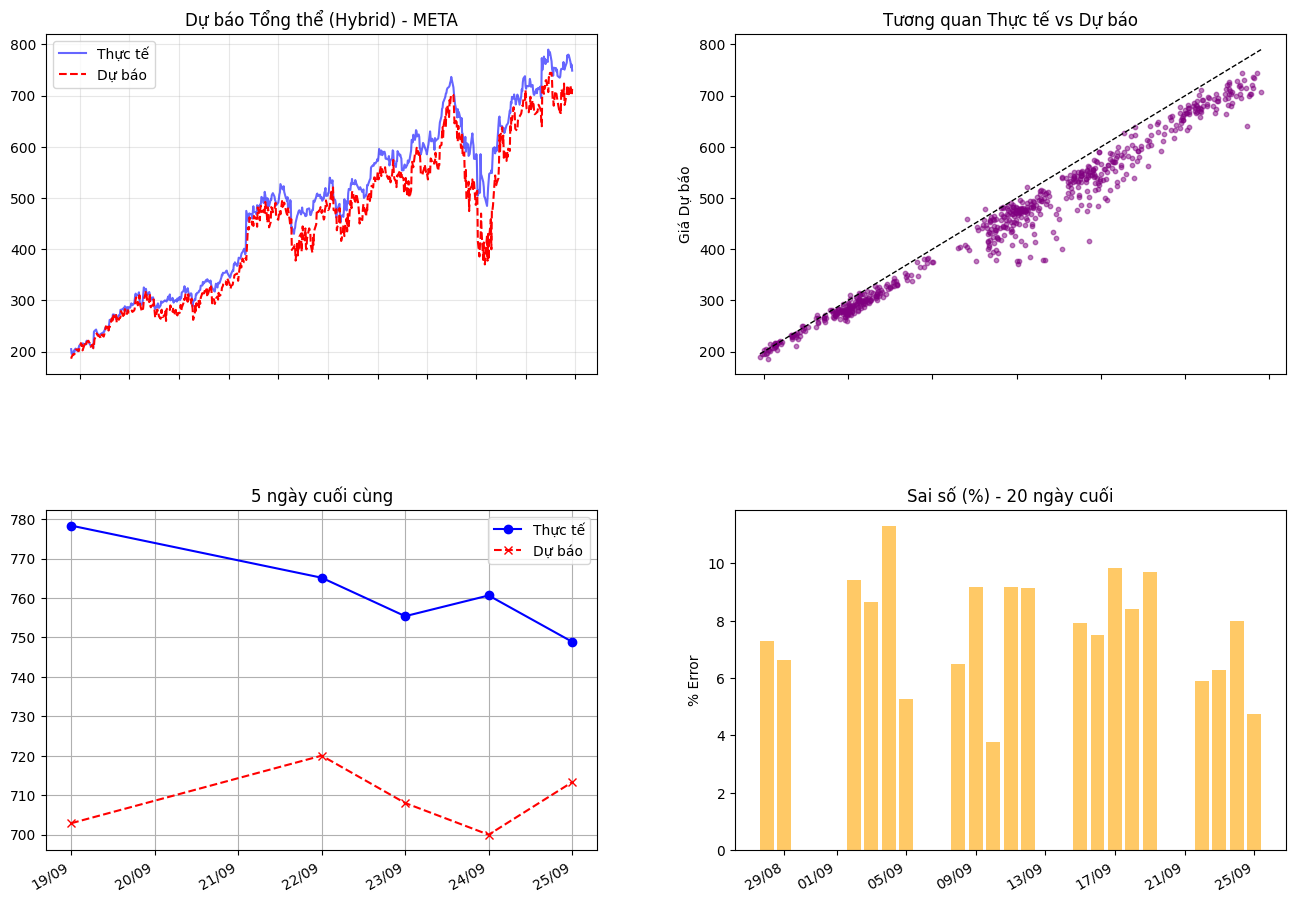

 >>> Hoàn thành: META

==================== ĐANG XỬ LÝ MÃ: VNM STOCK PRICE HISTORY ====================
 Lỗi nghiêm trọng tại mã VNM STOCK PRICE HISTORY: ['Lần cuối']

=================================== BẢNG ĐÁNH GIÁ VÀ DỰ BÁO NGÀY CUỐI ===================================

============================== KẾT QUẢ SO SÁNH CHI TIẾT ==============================


,Ticker,Mode,DA (%),MAPE (%),RMSE,MAE,R2,Actual Last,Pred Last
0,ALIBABA,Hybrid,48.5149,2.8465,3.2610,2.4777,0.9166,88.589996,88.988503
1,AMAZON,Hybrid,50.0000,3.8357,0.8268,0.6909,-22.6177,17.930000,16.618200
2,GOOGLE,Hybrid,56.6210,10.4985,18.6445,14.1719,0.5295,183.320007,153.407898
3,META,Hybrid,45.8991,6.6471,43.1624,34.1438,0.9287,748.909973,713.302917


Bảng kết quả đã được lưu thành ảnh tại: ..\..\CHART\DLINEAR+NODE\hybrid_evaluation_summary.png


In [10]:
all_metrics_results = []
valid_files = [f for f in os.listdir(PRICE_DIR) if f.endswith('.csv') and "_" not in f]

if not valid_files:
    print(f"Không tìm thấy file hợp lệ trong {PRICE_DIR}")
else:
    for filename in valid_files:
        target_ticker = filename.replace('.csv', '').upper()
        print(f"\n{'='*20} ĐANG XỬ LÝ MÃ: {target_ticker} {'='*20}")
        
        try:
            processor = HybridDataProcessor()
            file_path = os.path.join(PRICE_DIR, filename)
            dates, p_data, r_data, targets = processor.load_clean_data(file_path)
            
            # Tạo chuỗi dữ liệu
            X_p, X_r, Y, Y_dates = processor.prepare_sequences(dates, p_data, r_data, targets, SEQ_LEN)
            
            split = int(len(Y) * 0.8)
            train_p, test_p = torch.FloatTensor(X_p[:split]), torch.FloatTensor(X_p[split:])
            train_r, test_r = torch.FloatTensor(X_r[:split]), torch.FloatTensor(X_r[split:])
            train_y, test_y = torch.FloatTensor(Y[:split]), torch.FloatTensor(Y[split:])
            test_dates = Y_dates[split:]
            
            # DataLoaders
            train_loader = DataLoader(TensorDataset(train_p, train_r, train_y), batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(TensorDataset(test_p, test_r, test_y), batch_size=BATCH_SIZE)
            
            # Khởi tạo và huấn luyện
            model = HybridDLinearNodeModel(seq_len=SEQ_LEN, price_dim=X_p.shape[2], residual_dim=X_r.shape[2]).to(DEVICE)
            history, saved_path = train_model(model, train_loader, val_loader, target_ticker, epochs=EPOCHS)
            
            # TẢI LẠI MODEL DÙNG ĐƯỜNG DẪN TUYỆT ĐỐI
            abs_saved_path = os.path.abspath(saved_path)
            if os.path.exists(abs_saved_path):
                model.load_state_dict(torch.load(abs_saved_path, map_location=DEVICE))
                
                # Gọi hàm visualize (Đã cập nhật để trả về metrics và lưu .png)
                metrics = visualize_prediction(model, processor, test_p, test_r, test_y, target_ticker, test_dates)
                
                if metrics:
                    all_metrics_results.append(metrics)
                    print(f" >>> Hoàn thành: {target_ticker}")
            else:
                print(f" Lỗi: Không tìm thấy file model tại {abs_saved_path}")
                
        except Exception as e:
            print(f" Lỗi nghiêm trọng tại mã {target_ticker}: {str(e)}")
            continue

# --- HIỂN THỊ BẢNG ĐÁNH GIÁ TỔNG HỢP ---
if all_metrics_results:
    print("\n" + "="*35 + " BẢNG ĐÁNH GIÁ VÀ DỰ BÁO NGÀY CUỐI " + "="*35)
    summary_df = pd.DataFrame(all_metrics_results)
    
    # Sắp xếp lại thứ tự cột cho dễ nhìn
    display_cols = [
        'Ticker', 'Mode', 'DA (%)', 'MAPE (%)', 
        'RMSE', 'MAE', 'R2', 'Actual Last', 'Pred Last'
    ]
    
    summary_df = summary_df[display_cols].round(4)
    
    print("\n" + "="*30 + " KẾT QUẢ SO SÁNH CHI TIẾT " + "="*30)
    display(summary_df)
    
    # --- LƯU BẢNG KẾT QUẢ RA ẢNH ---
    fig, ax = plt.subplots(figsize=(14, 4)) # Điều chỉnh kích thước
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Lưu ảnh
    image_filename = "hybrid_evaluation_summary.png"
    image_path = os.path.join(CHART_DIR, image_filename)
    plt.savefig(image_path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    print(f"Bảng kết quả đã được lưu thành ảnh tại: {image_path}")